# chapter 3.15

「都内で発生した2つの地震の震源地間の間の距離は何kmですか？」という問題。  
Tableauのマップ上で円形選択ツールによってざっくりと11kmです、という回答例が示されている。

## 検証結果
Tableauがパワフルなデータ集計・可視化ツールであることに疑問の余地はないが、今回のようにピンポイントで値を求めるというユースケースには不向きである。  

実際、検証を行うと以下の点が明らかになった。

- 東京都内で発生した地震は7つある
- Tableau上で確認した距離は正確ではない

## データ準備

In [129]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
from shapely.geometry import Point, LineString

津波データの読み込み

In [3]:
df = pd.read_csv("3.15_sources.csv")

アクセスしやすいように列名のdictを作成

In [4]:
class dotdict(dict): 
    def __init__(self, *args, **kwargs): 
        super().__init__(*args, **kwargs) 
        self.__dict__ = self 

cols = dotdict({k:k for k in df.columns})

dfの列を絞り込む

In [5]:
df = df[[cols.SOURCE_ID, cols.LONGITUDE, cols.LATITUDE]]

GeoDataFrameに変換

In [6]:
gdf = gpd.GeoDataFrame(pd.concat(
    [df.SOURCE_ID, df.apply(lambda r: Point(r[cols.LONGITUDE], r[cols.LATITUDE]), axis=1).rename("geometry")], axis=1))

In [7]:
gdf

,SOURCE_ID,geometry
0,1,POINT (35.80000 35.68300)
1,3,POINT (25.40000 36.40000)
2,4,POINT (35.80000 35.68300)
3,5,POINT (26.24000 39.96000)
4,6,POINT (nan nan)
...,...,...
2577,5632,POINT (161.10700 -10.73000)
2578,5636,POINT (153.45000 -4.50900)
2579,5637,POINT (-73.88000 -43.41600)
2580,5639,POINT (176.05300 -19.32600)


In [8]:
import plotly.express as px

In [67]:
import plotly.graph_objects as go

東京都のポリゴン取得([市区町村のポリゴン作成](https://github.com/arakaki-tokyo/tableau_learning/blob/main/data/%E5%B8%82%E5%8C%BA%E7%94%BA%E6%9D%91%E3%81%AE%E3%83%9D%E3%83%AA%E3%82%B4%E3%83%B3%E4%BD%9C%E6%88%90.ipynb)で使用したデータ)

In [17]:
tokyo = gpd.read_file("13.zip").at[0, "geometry"]

震源地の座標が東京都のポリゴンに含まれる行だけ抽出

In [18]:
intokyo = gdf[gdf.within(tokyo)].reset_index(drop=True)

In [20]:
intokyo

,SOURCE_ID,geometry
0,5502,POINT (139.40000 34.73000)
1,427,POINT (139.80000 33.10000)
2,5445,POINT (142.21000 27.07000)
3,851,POINT (139.80000 35.65000)
4,5503,POINT (139.70000 35.60000)
5,5415,POINT (142.21000 27.07000)
6,2340,POINT (139.13100 34.22100)


描画して確認

In [174]:
def plot_sources(gdf, center=None, zoom=7.5):

    fig = px.scatter_mapbox(gdf,
                            lat=gdf.geometry.y,
                            lon=gdf.geometry.x,
                            hover_name=gdf.SOURCE_ID,
                            color=gdf.SOURCE_ID.astype(str),
                            mapbox_style="carto-darkmatter",
                            center=center,
                            zoom=zoom, width=800, height=600)

    fig.show()

In [173]:
[(x, y)] = tokyo.centroid.coords
center = dict(lon=x, lat=y)

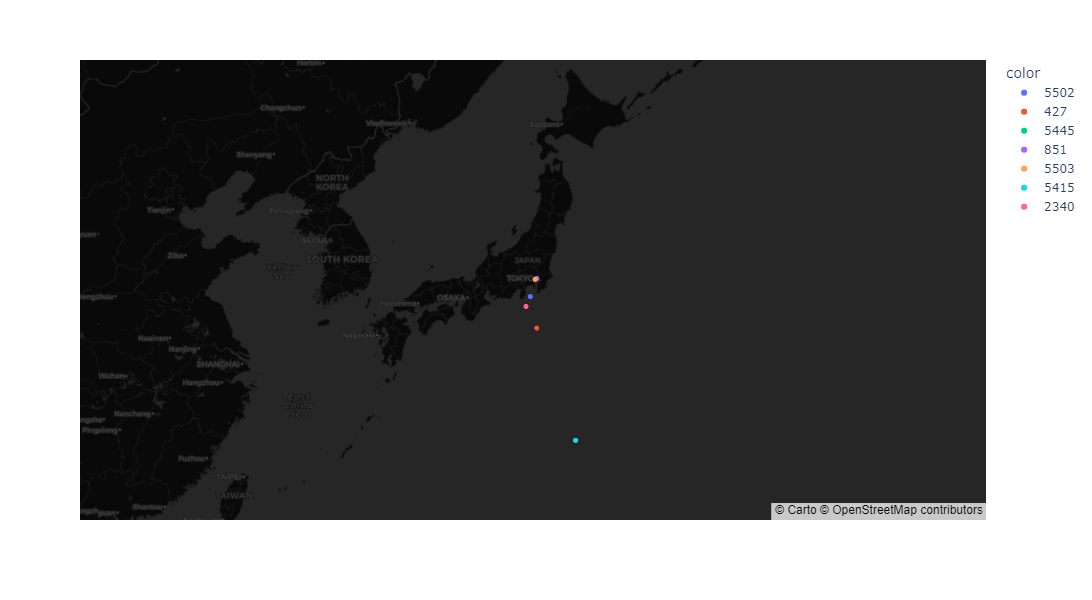

In [175]:
plot_sources(intokyo, center=center, zoom=3.5)

## ポイント間の距離

### geopandasを使う方法

地理座標系を設定

In [27]:
intokyo.set_crs(epsg=6668, inplace=True)

,SOURCE_ID,geometry
0,5502,POINT (139.40000 34.73000)
1,427,POINT (139.80000 33.10000)
2,5445,POINT (142.21000 27.07000)
3,851,POINT (139.80000 35.65000)
4,5503,POINT (139.70000 35.60000)
5,5415,POINT (142.21000 27.07000)
6,2340,POINT (139.13100 34.22100)


投影座標系に変換

In [179]:
intokyo2 = intokyo.to_crs(epsg=6677)

In [180]:
intokyo2

,SOURCE_ID,geometry
0,5502,POINT (-39683.872 -140803.472)
1,427,POINT (-3111.277 -321671.428)
2,5445,POINT (235765.862 -987830.968)
3,851,POINT (-3018.378 -38830.121)
4,5503,POINT (-12081.036 -44369.499)
5,5415,POINT (235765.862 -987830.968)
6,2340,POINT (-64710.528 -197124.147)


ポイント間の距離を算出(km)  
例えば本州が震源地の2点(5503, 851)間は10.6km

In [242]:
dists = (pd
         .DataFrame(np.tril([intokyo2.distance(intokyo2.iat[i, 1]) / 1000 for i in range(len(intokyo2))], k=-1))
         .rename(index=intokyo2.SOURCE_ID, columns=intokyo2.SOURCE_ID))
dists

,5502,427,5445,851,5503,5415,2340
5502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
427,184.528514,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5445,890.689697,707.694016,0.000000,0.000000,0.000000,0.000000,0.0
851,108.364766,282.841322,978.580871,0.000000,0.000000,0.000000,0.0
5503,100.306668,277.446962,975.473029,10.621509,0.000000,0.000000,0.0
5415,890.689697,707.694016,0.000000,978.580871,975.473029,0.000000,0.0
2340,61.630771,138.947806,845.874304,169.890906,161.566847,845.874304,0.0


### geopyを使う方法

In [199]:
from geopy.distance import geodesic

In [213]:
# Shapely.Pointsオブジェクトを(lat, lon)のタプルに変換
points = intokyo.geometry
*points, = zip(points.y, points.x)

In [243]:
cross_dist = []
for i in range(len(points)):
    cross_dist.append([geodesic(points[i], points[j]).km for j in range(len(points))])
dists2 = pd.DataFrame(np.tril(cross_dist, k=-1)).rename(index=intokyo2.SOURCE_ID, columns=intokyo2.SOURCE_ID)

In [244]:
dists2

,5502,427,5445,851,5503,5415,2340
5502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
427,184.545673,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5445,890.603531,707.605037,0.000000,0.000000,0.000000,0.000000,0.0
851,108.374846,282.869576,978.457611,0.000000,0.000000,0.000000,0.0
5503,100.315794,277.474489,975.358201,10.622563,0.000000,0.000000,0.0
5415,890.603531,707.605037,0.000000,978.457611,975.358201,0.000000,0.0
2340,61.634826,138.959191,845.803952,169.904831,161.579610,845.803952,0.0


結果はほぼ同じだが、計算方法の違いによって0.01%程度の差が出る。(1kmあたり0.1m)

In [261]:
# 相対誤差の平均
diff = np.abs(dists.to_numpy() - dists2.to_numpy()) / dists.to_numpy()
diff = diff.flatten()
diff = diff[~np.isnan(diff)]

diff.mean()

/tmp/ipykernel_315/813916526.py:2: RuntimeWarning:

invalid value encountered in true_divide



9.913180578755176e-05